<a href="https://colab.research.google.com/github/Lordborack/similarcards/blob/master/PBM_SDS_test_cloud.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# WORK LOG
TODO:
* comming notebook to git
* SVM + PCA DONE
* outline what you would do DONE
  * Feature selection, more important if overfiting is an issue
  * Few samples -> increas the CV to 10x5F cv *
  * Same decay that we have checked with lifetime_revenue do the same for more features
  * min time between two purchases, max time between purchases, ratio of lifetime_revenue of first 7d vs last 7d
  * study in more detail the 30 days evolution see if we can came out with some fit in a regression and use the fit parameters as features \$
  * combination of features....
  * CNN with 1x7 convolutional filter (x features) \$
  * ensemble *
  * outliers, if they are wrong recordings we just remove them. If they are not outliers, we could try to detect them and have a model just for them.
  * remove the country list to see if leaveone out encoding increases performance
  * more cleaning and transformations focusing on the LR \$
* eval best model with test.csv to report performance (LAST)
* send email with link and share repo

DONE:
* REFACTOR CODE IF NECESSARY DONE
* CREATE inferency.py DONE
* CREATE README DONE
  * How to execute the code
  * How is it organized
  * How is the best model
* RETRAIN MODELS AS PER THE REFACTOR DONE
* leave one out encoding DONE
* check if I remove the clamp in the target DONE


DONE:
* check that code makes sene and bugs DONE
* re read what is expected as a outcome ensure that I'm aligned (GIT, REVISAR, EXEMPLES CONCRETS DE LA MEVA FORMA DE PENSAR, SUPPOR PER FUTURES ENTREVISTES, ENVIAR TOT EL CODI, VISIÓ AMPLIA DE COM M'HE ENFRONTAT AL REPTE, EXPLICAR COM EXECUTAR AQUEST MODEL EN INFERENCIA PER DADES NOVES) DONE
* register results of experiments in colab DONE
* modularize train function -> !!!prioritari!!... inclou transformació de target variable, imputació de valors, summarize to a single record, encoding de categoricals DONE
* end2end Store model in memory re execute again DONE
* implement features for evolution of the main metrics over the first 30d DONE
* hyper param tuning DONE
* go for linear DONE

DONE:
* split data into 3. DONE
* build infrastructure for training and validation
    * easiest model possible -> 30d summary
* exploratory analysis DONE
    * strategy for countries and missing countries
    * and 3 numerical features
    * check that lifetime values are actually repeated across different records


#Exploratory analysis

##Load data

In [ ]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns',10)

x_train = pd.read_csv('https://scopely-data-interview.s3.us-east-1.amazonaws.com/X_train.csv')
y_train = pd.read_csv('https://scopely-data-interview.s3.us-east-1.amazonaws.com/y_train.csv')

In [ ]:
#pd.set_option('display.max_columns',10)
#%load_ext google.colab.data_table
x_train

,device_token_hash,days_since_install,install_date,platform_name,is_active,...,hc_lifetime_sink,hc_sink_daily_transactions,hc_lifetime_sink_transactions,hc_daily_transactions,hc_lifetime_transactions
0,4c56a8b2727e8036fd219cd1699aa6e9,3,2017-06-30,ios,False,...,553,0,16,0,24
1,4c56a8b2727e8036fd219cd1699aa6e9,9,2017-06-30,ios,False,...,553,0,16,0,24
2,4c56a8b2727e8036fd219cd1699aa6e9,0,2017-06-30,ios,True,...,553,16,16,24,24
3,4c56a8b2727e8036fd219cd1699aa6e9,28,2017-06-30,ios,False,...,553,0,16,0,24
4,4c56a8b2727e8036fd219cd1699aa6e9,20,2017-06-30,ios,False,...,553,0,16,0,24
...,...,...,...,...,...,...,...,...,...,...,...
250645,f6a2d1554f7250f2fe00d79f3b58e4f0,26,2017-06-09,ios,False,...,15087,0,161,0,240
250646,f6a2d1554f7250f2fe00d79f3b58e4f0,24,2017-06-09,ios,False,...,15087,0,161,1,240
250647,f6a2d1554f7250f2fe00d79f3b58e4f0,3,2017-06-09,ios,True,...,6617,37,82,50,120
250648,f6a2d1554f7250f2fe00d79f3b58e4f0,5,2017-06-09,ios,True,...,7842,15,97,20,140


there are repeated hashes. There is a column with days since install this implies a time series. That means that for each user we have a summary of each day.

In [ ]:
x_train.groupby('device_token_hash').size().reset_index(name='counts').sort_values('counts',ascending = False).describe()

,counts
count,9646.000000
mean,25.984864
std,7.306160
min,1.000000
25%,24.000000
50%,30.000000
75%,31.000000
max,31.000000


In [ ]:
looks like we have a month worth of data, about what those users have done. We have a daily record for most of the users, and for 75% of them at least 24 recrods.
RFM: recency, frequency, monetary value https://towardsdatascience.com/data-driven-growth-with-python-part-2-customer-segmentation-5c019d150444

(12633, 4)

In [ ]:
y_train.groupby('device_token_hash').size().reset_index(name='counts').shape

(12633, 2)

In [ ]:
we have the same number of unique ids in y_train. 

In [ ]:
y_train.describe()

,days_since_install,lifetime_revenue
count,12633.0,12633.000000
mean,365.0,369.228274
std,0.0,2126.435919
min,365.0,0.990000
25%,365.0,9.990000
50%,365.0,29.970000
75%,365.0,127.950000
max,365.0,123181.080000


In [ ]:
y_train

,device_token_hash,days_since_install,install_date,lifetime_revenue
0,b9885d6d14f8e67ea7e23c19c2c3b1b4,365,2017-06-15,4.99
1,4c56a8b2727e8036fd219cd1699aa6e9,365,2017-06-30,4.99
2,fe41a8d9bccda5fdb004292f889d8258,365,2017-06-14,31.96
3,3489af06cfd9ae901f0c9500dde928aa,365,2017-06-07,658.38
4,6ca6cc28b8d24c9f64794ac62a4115c5,365,2017-06-06,1.98
...,...,...,...,...
12628,e1ea904ae593124e8a121ff947484386,365,2017-06-04,159.93
12629,94ea6deb86575cf9b3a0e82be1c8d353,365,2017-06-02,341.80
12630,f70b775952a50f0b53423f442e283ce5,365,2017-06-22,50.90
12631,99774232ef7c8d0a0426271b4f78ee79,365,2017-06-09,9.99


In [ ]:
so this this is a 1M cohort and we have the LTV after one year of the first install. and then we have data from the first month of activity.

In [ ]:
import pandas as pd
x_train = pd.read_csv('https://scopely-data-interview.s3.us-east-1.amazonaws.com/X_train.csv')

x_train.columns

Index(['device_token_hash', 'days_since_install', 'install_date',
       'platform_name', 'is_active', 'days_since_last_activity',
       'days_to_first_purchase', 'days_since_last_purchase', 'first_country',
       'lifetime_revenue', 'daily_revenue', 'is_customer',
       'is_new_customer_today', 'is_payer_today', 'num_days_played',
       'daily_payments', 'lifetime_payments', 'is_facebook_connected',
       'push_enabled', 'last_hc_start_balance', 'last_hc_end_balance',
       'lifetime_app_opens', 'lifetime_failed_payments', 'daily_key_activity',
       'lifetime_key_activity', 'hc_daily_source', 'hc_lifetime_source',
       'hc_daily_sink', 'hc_lifetime_sink', 'hc_sink_daily_transactions',
       'hc_lifetime_sink_transactions', 'hc_daily_transactions',
       'hc_lifetime_transactions'],
      dtype='object')

there are daily and summary metrics of the first month. Summary metrics are good for a first iterations, daily metrics will help compute features that cach the evolution of the first 30d. Lifetime values are historified...

##let's check for missing data

In [ ]:
print(x_train.shape)
x_train.isna().sum()

(250650, 33)


device_token_hash                     0
days_since_install                    0
install_date                          0
platform_name                         0
is_active                             0
days_since_last_activity           6268
days_to_first_purchase                0
days_since_last_purchase              0
first_country                       601
lifetime_revenue                      0
daily_revenue                         0
is_customer                           0
is_new_customer_today                 0
is_payer_today                        0
num_days_played                       0
daily_payments                        0
lifetime_payments                     0
is_facebook_connected                 0
push_enabled                     155556
last_hc_start_balance             37092
last_hc_end_balance               37092
lifetime_app_opens                    0
lifetime_failed_payments              0
daily_key_activity                    0
lifetime_key_activity                 0


days_since_last_activity, first_country, push_enabled, last_hc_start_balance, last_hc_end_balance. 
For the categorical variable we are going to create a "MISSING" category
For the numerical we are going to use the mean of the fold.

for the sake of clarity let's check one record

In [ ]:
x_train[x_train['days_since_last_activity'].isna()]

,device_token_hash,days_since_install,install_date,platform_name,is_active,...,hc_lifetime_sink,hc_sink_daily_transactions,hc_lifetime_sink_transactions,hc_daily_transactions,hc_lifetime_transactions
32,38d2389e375e43acd578f577c28a44c2,24,2017-06-28,android,False,...,0,0,0,0,2
33,38d2389e375e43acd578f577c28a44c2,5,2017-06-28,android,False,...,0,0,0,0,2
34,38d2389e375e43acd578f577c28a44c2,14,2017-06-28,android,False,...,0,0,0,0,2
35,38d2389e375e43acd578f577c28a44c2,26,2017-06-28,android,False,...,0,0,0,0,2
36,38d2389e375e43acd578f577c28a44c2,28,2017-06-28,android,False,...,0,0,0,0,2
...,...,...,...,...,...,...,...,...,...,...,...
250538,11eae4430ff49007cf89fd6352ab8908,16,2017-06-27,android,False,...,0,0,0,0,495
250539,11eae4430ff49007cf89fd6352ab8908,8,2017-06-27,android,False,...,0,0,0,0,495
250540,11eae4430ff49007cf89fd6352ab8908,9,2017-06-27,android,False,...,0,0,0,0,495
250541,11eae4430ff49007cf89fd6352ab8908,19,2017-06-27,android,False,...,0,0,0,0,495


In [ ]:
pd.options.display.max_columns = None

x_train[x_train['device_token_hash' ]== '5725f0b715f08d546a1d5abb4063cc74'].sort_values(by = 'days_since_install')

y_train[y_train['device_token_hash' ]== '5725f0b715f08d546a1d5abb4063cc74'].sort_values(by = 'days_since_install')


,device_token_hash,days_since_install,install_date,lifetime_revenue
18,5725f0b715f08d546a1d5abb4063cc74,365,2017-06-24,8.99


days_since_last_activity = NAN is that they just have one intitial activity and no more....
push enabled NAN looks like FALSE

In [ ]:
x_train[x_train['last_hc_start_balance'].isna()] 

,device_token_hash,days_since_install,install_date,platform_name,is_active,days_since_last_activity,days_to_first_purchase,days_since_last_purchase,first_country,lifetime_revenue,daily_revenue,is_customer,is_new_customer_today,is_payer_today,num_days_played,daily_payments,lifetime_payments,is_facebook_connected,push_enabled,last_hc_start_balance,last_hc_end_balance,lifetime_app_opens,lifetime_failed_payments,daily_key_activity,lifetime_key_activity,hc_daily_source,hc_lifetime_source,hc_daily_sink,hc_lifetime_sink,hc_sink_daily_transactions,hc_lifetime_sink_transactions,hc_daily_transactions,hc_lifetime_transactions
0,4c56a8b2727e8036fd219cd1699aa6e9,3,2017-06-30,ios,False,3.0,0,3,US,4.99,0.00,True,False,False,1,0,1,False,False,NaN,NaN,16,0,0,24,0,745,0,553,0,16,0,24
1,4c56a8b2727e8036fd219cd1699aa6e9,9,2017-06-30,ios,False,9.0,0,9,US,4.99,0.00,True,False,False,1,0,1,False,False,NaN,NaN,16,0,0,24,0,745,0,553,0,16,0,24
2,4c56a8b2727e8036fd219cd1699aa6e9,0,2017-06-30,ios,True,0.0,0,0,US,4.99,4.99,True,True,True,1,1,1,False,False,NaN,NaN,16,0,24,24,745,745,553,553,16,16,24,24
3,4c56a8b2727e8036fd219cd1699aa6e9,28,2017-06-30,ios,False,28.0,0,28,US,4.99,0.00,True,False,False,1,0,1,False,False,NaN,NaN,16,0,0,24,0,745,0,553,0,16,0,24
4,4c56a8b2727e8036fd219cd1699aa6e9,20,2017-06-30,ios,False,20.0,0,20,US,4.99,0.00,True,False,False,1,0,1,False,False,NaN,NaN,16,0,0,24,0,745,0,553,0,16,0,24
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
250430,cce48ee25af72c494a1c6658b83a197c,8,2017-06-27,ios,True,0.0,2,2,FR,24.95,0.00,True,False,False,9,0,5,True,False,NaN,NaN,117,0,13,213,0,2518,0,2328,0,41,0,68
250437,cce48ee25af72c494a1c6658b83a197c,7,2017-06-27,ios,True,0.0,2,1,FR,24.95,0.00,True,False,False,8,0,5,True,False,NaN,NaN,111,0,10,200,0,2518,0,2328,0,41,0,68
250439,cce48ee25af72c494a1c6658b83a197c,11,2017-06-27,ios,True,0.0,2,5,FR,24.95,0.00,True,False,False,12,0,5,True,False,NaN,NaN,142,0,27,285,0,2518,0,2518,0,45,0,72
250552,e1ea904ae593124e8a121ff947484386,0,2017-06-04,android,True,0.0,0,0,US,4.99,4.99,True,True,True,1,1,1,False,NaN,NaN,NaN,3,0,5,5,625,625,4,4,2,2,7,7


In [ ]:
x_train[x_train['device_token_hash' ]== '4c56a8b2727e8036fd219cd1699aa6e9'].sort_values(by = 'days_since_install')



,device_token_hash,days_since_install,install_date,platform_name,is_active,days_since_last_activity,days_to_first_purchase,days_since_last_purchase,first_country,lifetime_revenue,daily_revenue,is_customer,is_new_customer_today,is_payer_today,num_days_played,daily_payments,lifetime_payments,is_facebook_connected,push_enabled,last_hc_start_balance,last_hc_end_balance,lifetime_app_opens,lifetime_failed_payments,daily_key_activity,lifetime_key_activity,hc_daily_source,hc_lifetime_source,hc_daily_sink,hc_lifetime_sink,hc_sink_daily_transactions,hc_lifetime_sink_transactions,hc_daily_transactions,hc_lifetime_transactions
2,4c56a8b2727e8036fd219cd1699aa6e9,0,2017-06-30,ios,True,0.0,0,0,US,4.99,4.99,True,True,True,1,1,1,False,False,NaN,NaN,16,0,24,24,745,745,553,553,16,16,24,24
26,4c56a8b2727e8036fd219cd1699aa6e9,1,2017-06-30,ios,False,1.0,0,1,US,4.99,0.00,True,False,False,1,0,1,False,False,NaN,NaN,16,0,0,24,0,745,0,553,0,16,0,24
6,4c56a8b2727e8036fd219cd1699aa6e9,2,2017-06-30,ios,False,2.0,0,2,US,4.99,0.00,True,False,False,1,0,1,False,False,NaN,NaN,16,0,0,24,0,745,0,553,0,16,0,24
0,4c56a8b2727e8036fd219cd1699aa6e9,3,2017-06-30,ios,False,3.0,0,3,US,4.99,0.00,True,False,False,1,0,1,False,False,NaN,NaN,16,0,0,24,0,745,0,553,0,16,0,24
25,4c56a8b2727e8036fd219cd1699aa6e9,4,2017-06-30,ios,False,4.0,0,4,US,4.99,0.00,True,False,False,1,0,1,False,False,NaN,NaN,16,0,0,24,0,745,0,553,0,16,0,24
15,4c56a8b2727e8036fd219cd1699aa6e9,5,2017-06-30,ios,False,5.0,0,5,US,4.99,0.00,True,False,False,1,0,1,False,False,NaN,NaN,16,0,0,24,0,745,0,553,0,16,0,24
12,4c56a8b2727e8036fd219cd1699aa6e9,6,2017-06-30,ios,False,6.0,0,6,US,4.99,0.00,True,False,False,1,0,1,False,False,NaN,NaN,16,0,0,24,0,745,0,553,0,16,0,24
8,4c56a8b2727e8036fd219cd1699aa6e9,7,2017-06-30,ios,False,7.0,0,7,US,4.99,0.00,True,False,False,1,0,1,False,False,NaN,NaN,16,0,0,24,0,745,0,553,0,16,0,24
22,4c56a8b2727e8036fd219cd1699aa6e9,8,2017-06-30,ios,False,8.0,0,8,US,4.99,0.00,True,False,False,1,0,1,False,False,NaN,NaN,16,0,0,24,0,745,0,553,0,16,0,24
1,4c56a8b2727e8036fd219cd1699aa6e9,9,2017-06-30,ios,False,9.0,0,9,US,4.99,0.00,True,False,False,1,0,1,False,False,NaN,NaN,16,0,0,24,0,745,0,553,0,16,0,24


looks like this guy made a single payment the first day and nothing the rest of the times. the balance is NAN probably because of that. 

* days_since_last_activity -> -1

* first_country / push_enabled -> MISSING

* last_hc_start_balance/ last_hc_end_balance -> -1

however, only country and push are going to be used in the first iteration. 
Country may be tricky lets have a look. 


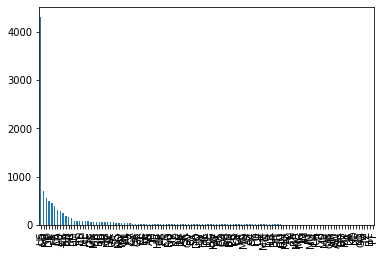

In [ ]:
x_train.loc[x_train['days_since_install'] == 30, 'first_country'].value_counts().plot(kind='bar')


there is 1 dominat county, many secondayr and lots with almost no represenation...

In [ ]:
total_first_countries = x_train.loc[x_train['days_since_install'] == 30, 'first_country'].value_counts().sum()
total_top_first_countries = x_train.loc[x_train['days_since_install'] == 30, 'first_country'].value_counts().head(10).sum()
total_top_first_countries/total_first_countries

0.817643391521197

we will keep the top 10 countries, the other will be 'RARE' and hte missing will be 'MISSING'

In [ ]:
x_train.loc[x_train['days_since_install'] == 30, 'first_country'].value_counts().head(10)

US    4310
GB     691
RU     557
DE     499
JP     444
FR     379
CA     306
AU     281
KR     232
BR     170
Name: first_country, dtype: int64

In [ ]:
print(total_first_countries)
x_train['device_token_hash'].nunique()

9624


9646

In [ ]:
x_train.groupby('device_token_hash').agg({'days_since_install':'min'}).describe()

,days_since_install
count,9646.000000
mean,5.015136
std,7.306160
min,0.000000
25%,0.000000
50%,1.000000
75%,7.000000
max,30.000000


we don't have the first day of most of those users...

##let's do a final check of all columns

In [ ]:
x_train['max_days_since_install'] = x_train.groupby('device_token_hash')['days_since_install'].transform('max') # should be the same as == 30
x_train[x_train['days_since_install'] == x_train['max_days_since_install']].describe()

,days_since_install,days_since_last_activity,days_to_first_purchase,days_since_last_purchase,lifetime_revenue,daily_revenue,num_days_played,daily_payments,lifetime_payments,last_hc_start_balance,last_hc_end_balance,lifetime_app_opens,lifetime_failed_payments,daily_key_activity,lifetime_key_activity,hc_daily_source,hc_lifetime_source,hc_daily_sink,hc_lifetime_sink,hc_sink_daily_transactions,hc_lifetime_sink_transactions,hc_daily_transactions,hc_lifetime_transactions
count,9646.0,9444.000000,9646.000000,9646.000000,9646.000000,9646.000000,9646.000000,9646.000000,9646.000000,8400.000000,8400.000000,9646.000000,9646.000000,9646.000000,9646.000000,9646.000000,9.646000e+03,9646.000000,9.646000e+03,9646.000000,9646.000000,9646.000000,9646.000000
mean,30.0,10.094769,5.015032,19.007672,114.662160,2.678559,17.477089,0.089363,4.517935,2434.332262,3218.455238,271.025192,0.015654,19.088119,629.326353,243.006428,1.067042e+04,248.843666,8.686772e+03,0.912814,65.814327,2.428675,137.424943
std,0.0,11.950568,7.306238,10.952499,845.610191,55.726046,11.994601,0.764625,13.944690,9493.504865,11036.828993,459.266470,0.688545,35.532033,835.097293,4586.678921,6.950405e+04,4592.476997,6.730970e+04,4.239459,110.334661,7.469686,596.504874
min,30.0,0.000000,-1.000000,0.000000,0.990000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000e+01,0.000000,0.000000e+00,0.000000,0.000000,0.000000,1.000000
25%,30.0,0.000000,0.000000,8.000000,9.980000,0.000000,5.000000,0.000000,1.000000,67.000000,75.000000,19.000000,0.000000,0.000000,43.000000,0.000000,1.265000e+03,0.000000,7.580000e+02,0.000000,14.000000,0.000000,37.000000
50%,30.0,2.000000,1.000000,23.000000,14.980000,0.000000,19.000000,0.000000,2.000000,191.000000,215.000000,98.000000,0.000000,0.000000,253.000000,0.000000,2.770000e+03,0.000000,1.901000e+03,0.000000,37.000000,0.000000,83.000000
75%,30.0,23.000000,7.000000,29.000000,59.980000,0.000000,30.000000,0.000000,4.000000,688.250000,817.250000,324.000000,0.000000,26.000000,940.750000,70.000000,7.022000e+03,0.000000,5.170250e+03,0.000000,80.000000,1.000000,156.000000
max,30.0,30.000000,30.000000,30.000000,72941.160000,4999.490000,31.000000,51.000000,784.000000,106375.000000,118894.000000,5306.000000,47.000000,404.000000,6762.000000,412320.000000,5.935200e+06,414564.000000,5.934999e+06,168.000000,4394.000000,203.000000,56211.000000


lifetime_revenue looks like is to much of a maximum, daily_payments same thing, lifetime_payments, last_hc_start_balance, lifetime_app_opens, and many more. 

In [ ]:
x_train['max_days_since_install'] = x_train.groupby('device_token_hash')['days_since_install'].transform('max') # should be the same as == 30
x_train_summary = x_train[x_train['days_since_install'] == x_train['max_days_since_install']].copy(deep=True)

x_train_summary['lifetime_revenue_th'] = x_train_summary['lifetime_revenue'].mean() + 2*x_train_summary['lifetime_revenue'].std()

x_train_summary[ x_train_summary['lifetime_revenue'] < x_train_summary['lifetime_revenue_th'] ].describe()

,days_since_install,days_since_last_activity,days_to_first_purchase,days_since_last_purchase,lifetime_revenue,...,hc_lifetime_sink_transactions,hc_daily_transactions,hc_lifetime_transactions,max_days_since_install,lifetime_revenue_th
count,9556.0,9355.000000,9556.000000,9556.000000,9556.000000,...,9556.000000,9556.000000,9556.000000,9556.0,9.556000e+03
mean,30.0,10.088616,5.052637,19.074927,76.854416,...,62.636040,2.328589,133.706990,30.0,1.805883e+03
std,0.0,11.933451,7.327093,10.909707,176.596641,...,84.669933,6.895985,593.816797,0.0,1.480280e-10
min,30.0,0.000000,-1.000000,0.000000,0.990000,...,0.000000,0.000000,1.000000,30.0,1.805883e+03
25%,30.0,0.000000,0.000000,9.000000,8.990000,...,14.000000,0.000000,37.000000,30.0,1.805883e+03
50%,30.0,2.000000,1.000000,23.000000,14.980000,...,37.000000,0.000000,82.000000,30.0,1.805883e+03
75%,30.0,23.000000,7.000000,29.000000,59.940000,...,79.000000,1.000000,153.000000,30.0,1.805883e+03
max,30.0,30.000000,30.000000,30.000000,1799.820000,...,1341.000000,172.000000,56211.000000,30.0,1.805883e+03


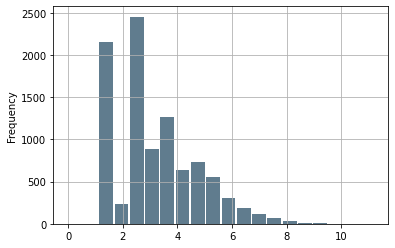

In [ ]:
x_train_summary['lifetime_revenue'].mean() + 2*x_train_summary['lifetime_revenue'].std()

x_train_summary['log_lifetime_revenue'] = np.log(x_train_summary['lifetime_revenue'])

x_train_summary['log_lifetime_revenue'].plot.hist(grid=True, bins=20, rwidth=0.9, color='#607c8e')


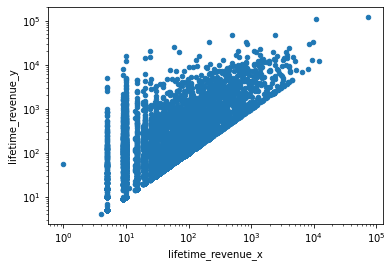

In [ ]:
plt = x_train_summary.merge(y_train, left_on = 'device_token_hash', right_on = 'device_token_hash', how = 'left').plot.scatter('lifetime_revenue_x', 'lifetime_revenue_y')

plt.set_xscale('log')
plt.set_yscale('log')



we will leave outliers as they are. Reason 1) I don't have enough business context to remove them perhapts they are true, 2) we will for for a RF which wont care about those. 3) if we work with a model that needs to normalize this date we will have to check if we remove them or log transform...

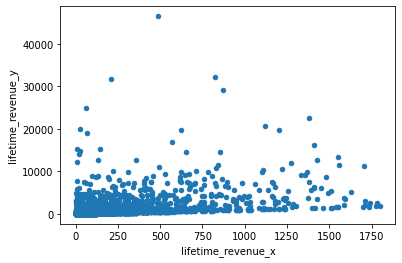

In [ ]:
plt = x_train_summary[x_train_summary['lifetime_revenue'] < x_train_summary['lifetime_revenue_th'] ].merge(y_train, left_on = 'device_token_hash', right_on = 'device_token_hash', how = 'left').plot.scatter('lifetime_revenue_x', 'lifetime_revenue_y')


In [ ]:
x_train_summary[ x_train_summary['lifetime_revenue'] < x_train_summary['lifetime_revenue_th'] ].describe()

,days_since_install,days_since_last_activity,days_to_first_purchase,days_since_last_purchase,lifetime_revenue,...,hc_daily_transactions,hc_lifetime_transactions,max_days_since_install,lifetime_revenue_th,log_lifetime_revenue
count,9556.0,9355.000000,9556.000000,9556.000000,9556.000000,...,9556.000000,9556.000000,9556.0,9.556000e+03,9556.000000
mean,30.0,10.088616,5.052637,19.074927,76.854416,...,2.328589,133.706990,30.0,1.805883e+03,3.169940
std,0.0,11.933451,7.327093,10.909707,176.596641,...,6.895985,593.816797,0.0,1.480280e-10,1.392123
min,30.0,0.000000,-1.000000,0.000000,0.990000,...,0.000000,1.000000,30.0,1.805883e+03,-0.010050
25%,30.0,0.000000,0.000000,9.000000,8.990000,...,0.000000,37.000000,30.0,1.805883e+03,2.196113
50%,30.0,2.000000,1.000000,23.000000,14.980000,...,0.000000,82.000000,30.0,1.805883e+03,2.706716
75%,30.0,23.000000,7.000000,29.000000,59.940000,...,1.000000,153.000000,30.0,1.805883e+03,4.093344
max,30.0,30.000000,30.000000,30.000000,1799.820000,...,172.000000,56211.000000,30.0,1.805883e+03,7.495442


In [ ]:

listOfCountries = ['US', 'GB'  ,'RU' , 'DE' , 'JP', 'FR', 'CA', 'AU', 'KR', 'BR']
x_train.loc[~x_train['first_country'].isin(listOfCountries), 'first_country'] = 'RARE'


,device_token_hash,days_since_install,install_date,platform_name,is_active,...,hc_sink_daily_transactions,hc_lifetime_sink_transactions,hc_daily_transactions,hc_lifetime_transactions,max_days_since_install
0,4c56a8b2727e8036fd219cd1699aa6e9,3,2017-06-30,ios,False,...,0,16,0,24,30
1,4c56a8b2727e8036fd219cd1699aa6e9,9,2017-06-30,ios,False,...,0,16,0,24,30
2,4c56a8b2727e8036fd219cd1699aa6e9,0,2017-06-30,ios,True,...,16,16,24,24,30
3,4c56a8b2727e8036fd219cd1699aa6e9,28,2017-06-30,ios,False,...,0,16,0,24,30
4,4c56a8b2727e8036fd219cd1699aa6e9,20,2017-06-30,ios,False,...,0,16,0,24,30


In [ ]:
x_train[x_train['device_token_hash']=='5725f0b715f08d546a1d5abb4063cc74'].sort_values('days_since_install')

,device_token_hash,days_since_install,install_date,platform_name,is_active,...,hc_sink_daily_transactions,hc_lifetime_sink_transactions,hc_daily_transactions,hc_lifetime_transactions,max_days_since_install
216,094a836e4ddf13c42e9eba71c234824c,1,2017-06-18,ios,True,...,3,8,5,19,30
214,094a836e4ddf13c42e9eba71c234824c,2,2017-06-18,ios,True,...,1,9,3,22,30
233,094a836e4ddf13c42e9eba71c234824c,3,2017-06-18,ios,True,...,5,14,5,27,30
217,094a836e4ddf13c42e9eba71c234824c,4,2017-06-18,ios,False,...,0,14,0,27,30
228,094a836e4ddf13c42e9eba71c234824c,5,2017-06-18,ios,True,...,1,15,1,28,30
235,094a836e4ddf13c42e9eba71c234824c,6,2017-06-18,ios,True,...,0,15,2,30,30
238,094a836e4ddf13c42e9eba71c234824c,7,2017-06-18,ios,True,...,1,16,4,34,30
212,094a836e4ddf13c42e9eba71c234824c,8,2017-06-18,ios,True,...,2,18,12,46,30
223,094a836e4ddf13c42e9eba71c234824c,9,2017-06-18,ios,True,...,0,18,1,47,30
219,094a836e4ddf13c42e9eba71c234824c,10,2017-06-18,ios,True,...,0,18,0,47,30


#Dependend variable. 

It is a long tail distribution that represents the LTV. Here I'll assume that we interesed in having good estiamations of LTV across all ids. That is, if an LTV of 1000 is estimated as beeing 1010, this is a better estimation (and hence in contributes less to the error) than an LTV of 10 that is estimated as 20. In the MAE critertia both will contribute to 10^2 to the error. However, my feeling for this problem is that the second estimation  (10 vs 20) should contribute more to the error. For this reason we are goint to optimie the RMSLE (root mean square logarithmic erro) instead of MAE. In this seting the error of the first estimation will be log(1000/1010)  vs log(10/20)

In [ ]:
print(np.sqrt(np.log(1000/1010)**2))
print(np.sqrt(np.log(10/20)**2))


0.009950330853168092
0.6931471805599453


I'll log transform the dependent variable so that when algoritms optimize the MSE they actually optimize the RMSLE.

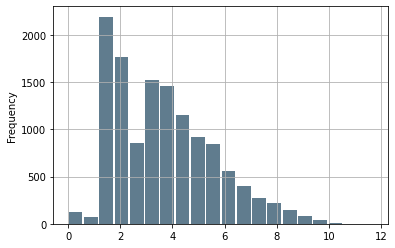

In [ ]:
import numpy as np
y_train['log_lifetime_revenue'] = np.log(y_train['lifetime_revenue'])
y_train['log_lifetime_revenue'].plot.hist(grid=True, bins=20, rwidth=0.9, color='#607c8e')
#.xscale('log')


In [ ]:
x_train.groupby('device_token_hash').agg({'days_since_install': "max", 
                                          'is_active': "max",
                                          'days_to_first_purchase': 'max', 
                                          'first_country':'max',
                                          'num_days_played' : 'max',
                                          'lifetime_payments' : 'max',
                                          'is_facebook_connected' : 'max',
                                          'push_enabled' : 'max',
                                          'lifetime_app_opens' : 'max',
                                          'lifetime_failed_payments' : 'max',
                                          'lifetime_key_activity' : 'max',
                                          'hc_lifetime_source' : 'max',
                                          'hc_lifetime_sink' : 'max',
                                          'hc_lifetime_sink_transactions' : 'max',
                                          'hc_daily_transactions' : 'max',
                                          'hc_lifetime_transactions' : 'max'

                                          })

,days_since_install,is_active,days_to_first_purchase,first_country,num_days_played,lifetime_payments,is_facebook_connected,push_enabled,lifetime_app_opens,lifetime_failed_payments,lifetime_key_activity,hc_lifetime_source,hc_lifetime_sink,hc_lifetime_sink_transactions,hc_daily_transactions,hc_lifetime_transactions
device_token_hash,,,,,,,,,,,,,,,,
00041f258790d6133d20d9b245781a4e,30,True,0,US,4,4,True,NaN,26,0,33,5299,5297,77,47,93
000c924ae684f72db413ae9eccf4d60a,30,True,1,SE,7,5,False,False,48,0,75,2399,2371,66,18,87
000eb7faf34d35218f20006c1fd34964,30,True,1,US,19,8,True,False,224,0,837,17478,16570,259,61,313
00170a3a2723687edb5aedc92eafd3d9,30,True,0,CA,24,1,False,NaN,701,0,480,1281,127,15,22,46
001e3f7f280f768907a9d03019cf3e3d,30,True,1,KR,24,1,True,NaN,142,0,178,2990,2769,13,10,63
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ffeb8321da47d6b6c0660e659626ce89,30,True,4,US,31,7,False,NaN,63,0,1209,4252,4120,55,23,121
fff614d94a58922d4b65397dcbb233f1,30,True,0,FR,1,1,True,True,6,0,10,693,73,26,36,36
fffa5c5e47ab040c78d6f7cfc799d7a7,30,True,29,UA,31,1,False,False,415,0,1142,3107,2814,17,5,140


tenim countries, tenum nan a push_enabled

#Ways to include the evolution of the first 30 days

we have many quantites such as the  daily_key_activity, daily_payments , daily_revenue, is_active. So far we have used only ther lifetimevalue at day 30d. However, a user that by the day 30d has spent 30\$, It may have spend 30\$ the first day only, the last day only or it may have spend it 1$ each day. I believe that this "evolution over time" must have and impact in the LTV.
Among many options I'll try to encode this information on vectors, make clusters of those vectors, and translate the "evolution over time" of each user to distance features to the centroids of those clustres. This just one way of dealing with that. 

In [ ]:
import numpy as np
lmd = 0.1
x_train = x_train[['days_since_install','daily_revenue','device_token_hash']].assign(w_daily_revenue = x_train['daily_revenue']*np.exp(lmd*(x_train['days_since_install'] -30)))
x_train.groupby('device_token_hash').agg({'w_daily_revenue':'sum'})

,w_daily_revenue
device_token_hash,
00041f258790d6133d20d9b245781a4e,3.344288
000c924ae684f72db413ae9eccf4d60a,1.491372
000eb7faf34d35218f20006c1fd34964,26.931085
00170a3a2723687edb5aedc92eafd3d9,0.248437
001e3f7f280f768907a9d03019cf3e3d,0.549682
...,...
ffeb8321da47d6b6c0660e659626ce89,6.119308
fff614d94a58922d4b65397dcbb233f1,0.248437
fffa5c5e47ab040c78d6f7cfc799d7a7,8.134488


In [ ]:
exp(-3)

0.049787068367863944

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer
from sklearn.decomposition import PCA
from sklearn import cluster

class PivotOneColumnSummarizeToSingleRecordPerIdTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, features, pivot, value):
        self.features = features
        self.pivot = pivot
        self.value = value

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):

        df = X.copy(deep=True)
        data_id_pivot_value = df[['device_token_hash',self.value, self.pivot]].pivot(index = 'device_token_hash', columns = self.pivot, values = self.value ).fillna(0)
        print(data_id_pivot_value.head())
        data_id_pivot_value = data_id_pivot_value.add_prefix(self.value+'_')
        data_id_pivot_value.rename({self.pivot+'_device_token_hash' : 'device_token_hash'}, inplace=True)

        df['max_days_since_install'] = df.groupby('device_token_hash')['days_since_install'].transform('max')
        df_summary = df.loc[df['days_since_install'] == df['max_days_since_install'], self.features].copy(deep=True).reset_index(drop=True)

        return df_summary.merge(data_id_pivot_value, left_on = 'device_token_hash', right_on = 'device_token_hash')


class ClusterFeatureGroup(BaseEstimator, TransformerMixin):
    def __init__(self, base_feature_name, k = 5):
        self.k = k
        self.features_to_transform =[base_feature_name +'_' + str(i) for i in range(0,31)]
        self.model = generate_kmeans_model(self.k)
        self.base_new_feature_name = 'cluster_component_'

    def fit(self, X, y = None):
        self.model.fit(X[self.features_to_transform])
        return self

    def transform(self, X, y = None):

        df = X.copy(deep=True)

        new_features = self.model.transform(df[self.features_to_transform])
        new_features_df = pd.DataFrame(new_features, columns= [self.base_new_feature_name + str(num) for num in range(0, new_features.shape[1])] )
        df_new_and_old_features = pd.concat([df, new_features_df], axis = 1)
        df_new_and_old_features.drop(self.features_to_transform, inplace = True, axis = 1)
  
        return df

class ExpnentialDecayOf(BaseEstimator, TransformerMixin):
    def __init__(self, feature,  lmd = 0.1):
        self.feature = feature
        self.lmd = lmd

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        df = X.copy(deep=True)
        df_exponential_decay = df[['days_since_install',self.feature,'device_token_hash']].assign(exponential_decay_measure = df[self.feature]*np.exp(self.lmd*(df['days_since_install'] -30)))
        df = df.merge(df_exponential_decay.groupby('device_token_hash').agg({'exponential_decay_measure':'sum'}), right_on = 'device_token_hash', left_on = 'device_token_hash')
        new_feature_name =  'exponential_decay_'+self.feature
        df.rename(columns={'exponential_decay_measure': new_feature_name}, inplace = True)
        return df

def generate_kmeans_model(k = 5):

    pipe = Pipeline([('normalize',Normalizer(norm = 'l1')),('scaler', StandardScaler()), ('pca', PCA(n_components=5)),('kmeans',cluster.KMeans(init='k-means++', n_clusters=k, n_init=10))])

    return pipe

In [ ]:

expdecay = ExpnentialDecayOf('daily_revenue')
expdecay.fit(x_train)
aa = expdecay.transform(x_train)
summarizer = PivotOneColumnSummarizeToSingleRecordPerIdTransformer(['device_token_hash', 'daily_revenue', 'exponential_decay_daily_revenue',  'lifetime_revenue'],'days_since_install','lifetime_revenue' )

summarizer.fit(aa)
bb=summarizer.transform(aa)
mycluster = ClusterFeatureGroup('lifetime_revenue')
mycluster.fit(bb)
cc = mycluster.transform(bb)
cc.head()



days_since_install                   0      1      2      3       4   ...  \
device_token_hash                                                     ...   
00041f258790d6133d20d9b245781a4e  54.97  54.97  64.96  64.96   64.96  ...   
000c924ae684f72db413ae9eccf4d60a   0.00   9.98  19.96  24.95   24.95  ...   
000eb7faf34d35218f20006c1fd34964   0.00   4.99  19.97  19.97  129.95  ...   
00170a3a2723687edb5aedc92eafd3d9   4.99   4.99   4.99   4.99    4.99  ...   
001e3f7f280f768907a9d03019cf3e3d   0.00   9.99   9.99   9.99    9.99  ...   

days_since_install                    26      27      28      29      30  
device_token_hash                                                         
00041f258790d6133d20d9b245781a4e   64.96   64.96   64.96   64.96   64.96  
000c924ae684f72db413ae9eccf4d60a   24.95   24.95   24.95   24.95   24.95  
000eb7faf34d35218f20006c1fd34964  194.92  194.92  194.92  194.92  194.92  
00170a3a2723687edb5aedc92eafd3d9    4.99    4.99    4.99    4.99    4.99  
001e3f7f28

,device_token_hash,daily_revenue,exponential_decay_daily_revenue,lifetime_revenue,lifetime_revenue_0,...,lifetime_revenue_26,lifetime_revenue_27,lifetime_revenue_28,lifetime_revenue_29,lifetime_revenue_30
0,4c56a8b2727e8036fd219cd1699aa6e9,0.00,0.248437,4.99,4.99,...,4.99,4.99,4.99,4.99,4.99
1,3489af06cfd9ae901f0c9500dde928aa,19.99,19.990000,19.99,0.00,...,0.00,0.00,0.00,0.00,19.99
2,38d2389e375e43acd578f577c28a44c2,0.00,2.986228,59.98,59.98,...,59.98,59.98,59.98,59.98,59.98
3,1e542d08d2ff769f2944cd606f6d7904,0.00,0.606884,9.98,0.00,...,9.98,9.98,9.98,9.98,9.98
4,4954e04780ad1c73483f016ffb358cf9,0.00,47.286401,154.90,9.99,...,154.90,154.90,154.90,154.90,154.90


In [ ]:
bb = mycluster.transform(aa)

In [ ]:
aa.rename({0:'zero'},inplace=True)
bb = aa.columns[0:2]
for i in range(0,32):
  bb.append('days_since_install' +'_'+str(i))

TypeError: ignored

In [ ]:
aa=summarizer.transform(x_train)
aa = aa.add_prefix('days_since_install_')
aa.rename({'days_since_install_device_token_hash' : 'device_token_hash', 'days_since_install_lifetime_revenue':'lifetime_revenue'}, inplace=True)
aa.head()

0
1
2
3


,days_since_install_device_token_hash,days_since_install_lifetime_revenue,days_since_install_0,days_since_install_1,days_since_install_2,...,days_since_install_26,days_since_install_27,days_since_install_28,days_since_install_29,days_since_install_30
0,4c56a8b2727e8036fd219cd1699aa6e9,4.99,4.99,4.99,4.99,...,4.99,4.99,4.99,4.99,4.99
1,3489af06cfd9ae901f0c9500dde928aa,19.99,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,19.99
2,38d2389e375e43acd578f577c28a44c2,59.98,59.98,59.98,59.98,...,59.98,59.98,59.98,59.98,59.98
3,1e542d08d2ff769f2944cd606f6d7904,9.98,0.00,0.00,9.98,...,9.98,9.98,9.98,9.98,9.98
4,4954e04780ad1c73483f016ffb358cf9,154.90,9.99,9.99,9.99,...,154.90,154.90,154.90,154.90,154.90


#Models evaluation

## No feature engineering RF, XGBOOST, LR basicPipleine  (rmsle)

* RF No target transform 1.3
* RF 0.711
* LR 2.48
* LR + LogTransform of lifetime_revenue_feature 0.718
* XGBOOST 0.705

the gain of XGBoost is of only 2.5%. Checking the feature importance it turns out the lifetime_revenue is the top most important. This implies that most of the gain of those methos are within that feature, and like the rest are not important and don't add value to the rmsle. We could exploit it more or getting more features on board. All in all RF with not logtransform of the target was about 1.3, so the big gain is in logtransfroming the target. 

## 6 extra feautes 1 + 5 (exponential decay and cluster-historified lifetime reveneu)

* RF 0.706
* LR 0.708
* XGBOOST 0.702
* PCA+SVM 0.98 (not fine tuned)

## leave one out encoding
* RF 0.705
* XGBOOST 0.706/0.707(sigma0.3)

It looks like the new features were usefull for RF, for XGBOOST looks like the onehotecoding is making him overfit. Over all the major improvement is for RF to logtransform the target and for LR to logtransform the feature. Besides those two transformations. The imporvemnt of XGBOOST over LR is (0.718 - 0.702) /  0.718 =  2.2%


Feature importance of random forest after using the extra features. Note that there is no gain in rmsle. nor for the few historified features I have tried.  

In [ ]:
'daily_key_activity': 0.04676065129790975, 'is_active': 0.019616388226528714, 'hc_lifetime_source': 0.20178649662960196, 'hc_lifetime_sink': 0.13119289815633056, 'hc_lifetime_sink_transactions': 0.02065559324481739, 'hc_lifetime_transactions': 0.01879941072660241, 'lifetime_key_activity': 0.0525144395256873, 'lifetime_failed_payments': 0.00014572300660824775, 'lifetime_app_opens': 0.024977375638633083, 'push_enabled': 0.0014890067039243105, 'is_facebook_connected': 0.002391011199320119, 'lifetime_payments': 0.10167816487562006, 'platform_name': 0.0014227714746755456, 'days_since_last_activity': 0.028130683657244797, 'days_to_first_purchase': 0.012440097484610097, 'days_since_last_purchase': 0.0634558310301019, 'first_country': 0.006899961042264569, 'lifetime_revenue': 0.22809389243688838, 'is_customer': 0.0, 'daily_payments_component_0': 0.00786129793163427, 'daily_payments_component_1': 0.006631282389595156, 'daily_payments_component_2': 0.008047849431755254, 'daily_payments_component_3': 0.007442024962376181, 'daily_payments_component_4': 0.0075671489272699415}


In [ ]:
y_train[y_train['lifetime_revenue'] > 22025]

x_train.merge(y_train[y_train['lifetime_revenue'] > 22025], left_on = 'device_token_hash', right_on = 'device_token_hash', how = 'inner' ).groupby('device_token_hash').agg({'lifetime_revenue_y':'max'})

,lifetime_revenue_y
device_token_hash,
082153116d5411349c7c1ef0535aa140,123181.08
1007fd029ab38d82c33194059ff7b768,29281.80
20bbf35f25ef0fa28b76583d7a6931ca,31755.81
31c72c14396ac3f1cf22d3c9f89cf09b,46912.95
3e71e49191f3053c77731f4e9a89fec7,110725.07
6b893f849ce1c048a4766ae7d6bf8823,24838.01
98c8a330d60d4a1ccae45c0a1f27aa21,29054.88
a5e35a0e752da244d7885e08f861a09a,31818.64
cc5259e0cfdb449a42cb2bcc066a34f8,22680.74


In [ ]:
np.log1p(123181.08)

11.721418864956563

In [ ]:
(0.718 - 0.702) /  0.718 

0.022284122562674116

In [ ]:
from sklearn.preprocessing.o

In [ ]:
!pip install category_encoders
from category_encoders import LeaveOneOutEncoder

     |████████████████████████████████| 81kB 2.1MB/s 


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
ce.LeaveOneOutEncoder

     |████████████████████████████████| 6.8MB 2.7MB/s 
  Found existing installation: scikit-learn 0.22.2.post1
    Uninstalling scikit-learn-0.22.2.post1:
      Successfully uninstalled scikit-learn-0.22.2.post1
